# MNIST 数据集

在第一部分，我们从零开始，帮助小明创建了一个预测冰激凌销量的多层神经网络模型。

在这个过程中，我们深入了解了人工神经元的概念，掌握了神经网络模型的三条核心数据链路：**前向传播**、**梯度计算**和**反向传播**，并认识到神经网络的核心逻辑正是基于微积分的**梯度下降**算法。

在第二部分，我们再次从零开始，构建了一个神经网络训练框架的核心组件：**张量类**、**层类**、**损失函数类**、**优化器类**和**数据集类**，最后用**模型类**将这些组件封装在一起。

通过这一工程化的封装，我们实现了**动态计算图**和**自动微分**机制，让三条数据链路的运行变得自动化且高效。

预测冰激凌销量是一个典型的**数值回归问题**。我们构建的神经网络训练框架已经能够游刃有余地处理此类任务。

---

在接下来的第三部分，我们将继续扩展这个神经网络训练框架，使其支持**分类问题**。更重要的是，我们将跨入图像处理的领域，探索如何处理**二维特征值**。这将让神经网络模型拥有“视觉”，使其能够真正“看到”并“看懂”图像。

In [7]:
import matplotlib.pyplot as plt
from abc import abstractmethod, ABC

import numpy as np

np.random.seed(99)

## 基础架构

### 张量

为了让张量可以批处理多维度数据（比如图像是二维数据），我们再次修改**特征维度**（size）属性，返回数据除了第一个维度（批次维度）以外，其他各维度的特征数量总和。

比如：批大小是 2，张量的数据是两个 3 × 3 的二维图像数据。那么其数据结构为 (2, 3, 3)，特征维度（size）将返回 9。

In [8]:
class Tensor:

    def __init__(self, data):
        self.data = np.array(data)
        self.grad = np.zeros_like(self.data)
        self.gradient_fn = lambda: None
        self.parents = set()

    def backward(self):
        if self.gradient_fn:
            self.gradient_fn()

        for p in self.parents:
            p.backward()

    @property
    def size(self):
        return np.prod(self.data.shape[1:])

    def __repr__(self):
        return f'Tensor({self.data})'

### 基础数据集

In [9]:
class Dataset(ABC):

    def __init__(self, batch_size=1):
        self.batch_size = batch_size
        self.load()
        self.train()

    @abstractmethod
    def load(self):
        pass

    def train(self):
        self.features = self.train_features
        self.labels = self.train_labels

    def eval(self):
        self.features = self.test_features
        self.labels = self.test_labels

    def shape(self):
        return Tensor(self.features).size, Tensor(self.labels).size

    def items(self):
        return Tensor(self.features), Tensor(self.labels)

    def __len__(self):
        return len(self.features) // self.batch_size

    def __getitem__(self, index):
        start = index * self.batch_size
        end = start + self.batch_size

        feature = Tensor(self.features[start: end])
        label = Tensor(self.labels[start: end])
        return feature, label

## 数据

### MINST 数据集

MNIST 数据集是“视觉”机器学习界的 Hello World!。

它包含了 70,000 张手写数字的灰度图片（分为训练数据和测试数据）。虽然对人类来说，分辨从 0 到 9 轻而易举，但对计算机而言，这只是一个数值从 0 到 255 变化的 28 × 28 像素点阵。

在这一部分，我们的目标是：扩展我们的神经网络训练框架，从而能够构建一个网络模型，从这些看似杂乱的像素中，提取出“笔画”和“形状”信息，并最终告诉我们：这写的是几？

### 数据预处理

加载完 MNIST 数据集以后，我们并不能直接将其用于模型训练。而是需要进行一系列数据预处理操作，以提升模型训练的稳定性、收敛速度与最终性能。主要包括以下三个关键步骤：

* **归一化**（Normalization）

MNIST 图像的像素值为 0 – 255 的整数。若直接用于模型训练，较大的数值范围可能导致**梯度爆炸**（Exploding Gradient）、或者**梯度消失**（Vanishing Gradient）。

<div style="border-left: 4px solid #4CAF50; background:#f9f9f9; padding:10px; margin:10px 0;">
<strong>💡 提示：</strong> 输入值过大，在模型训练的过程中，经过层层计算，可能造成梯度呈指数级别迅速提高或者降低（接近于零），从而导致<strong>梯度爆炸</strong>或者<strong>梯度消失</strong>。
</div>

为此，我们通常将像素值除以 255，将其线性缩放到 [0, 1] 区间。这不仅统一了输入尺度，也更符合多数激活函数与优化器对输入分布的隐含假设。

* **维度扩展**（Dimension Expansion）

MNIST 图像数据结构是三维 ($n$, 28, 28)。其中 $n$ 为样本数量，后两维表示图像的高度与宽度。

MNIST 图像是灰度图（单通道），因此没有代表颜色的维度（通道）。我们需要给它增加一个维度，转换为四维 ($n$, 1, 28, 28)，和其他彩色图像保持一致。

* **标签独热编码**（One-Hot Encoding）

MNIST 标签为 0 – 9 的整数。这些数字不代表大小，只代表类别。若直接以整型作为标签，可能使模型误以为是数值回归问题，而不是分类问题。

通过独热编码，我们将每个标签转换为一个长度为 10 的向量。例如标签 2 会被编码为 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]。通过这种方式，让模型明白，需要学习的是标签的位置，而不是大小。

<div style="border-left: 4px solid #4CAF50; background:#f9f9f9; padding:10px; margin:10px 0;">
<strong>💡 提示：</strong> <strong>独热编码</strong>是一种将标签从数值转换成位置向量的方法。每个类别只在向量的对应位置为 1，其余位置皆为 0。用于明确告诉模型这是一个分类问题，不是数值回归问题。
</div>

In [10]:
class MINSTDataset(Dataset):

    def __init__(self, filename, batch_size=1):
        self.filename = filename
        super().__init__(batch_size)

    def load(self):
        with (np.load(self.filename, allow_pickle=True) as f):
            self.train_features, self.train_labels = self.normalize(f['x_train'], f['y_train'])
            self.test_features, self.test_labels = self.normalize(f['x_test'], f['y_test'])

    @staticmethod
    def normalize(x, y):
        # 归一化
        inputs = x / 255
        # 维度扩展
        inputs = np.expand_dims(inputs, axis=1)
        # 独热编码
        targets = np.zeros((len(y), 10))
        targets[range(len(y)), y] = 1
        return inputs, targets

## 验证

### 测试

为了加快模型训练速度，我们从 MNIST 数据集中随机选择了 2000 个训练数据、和 1000 个测试数据，组成了 TinyMINST 数据集。我们将使用这个 MNIST 的子集作为训练数据。

In [11]:
dataset = MINSTDataset('tinymnist.npz')

print(f'train data count: {len(dataset.train_features)}')
print(f'test data count: {len(dataset.test_features)}')

feature, label = dataset[0]

print(f'feature shape: {feature.data.shape}')
print(f'label shape: {label.data.shape}')

train data count: 2000
test data count: 1000
feature shape: (1, 1, 28, 28)
label shape: (1, 10)


### 图例

最后，让我们看一下 MNIST 图像看起来是什么样子。

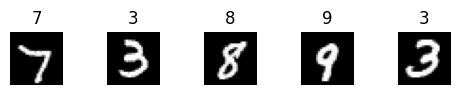

In [12]:
fig, axes = plt.subplots(1, 5, figsize=(5, 1))

for i in range(5):
    feature, label = dataset[i]
    image = feature.data.squeeze()
    label = np.argmax(label.data)

    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(label)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 课后练习

跟踪一下代码，看一看预处理后的特征值和标签值分别是什么样子的？分辨一下哪个是批次维度，以及颜色通道维度；感受一下独热编码的效果。